In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [22]:
train_df = pd.read_csv(
    "/Users/rahulanil/garchomp/projects/kaggle/titanic/data/train.csv"
)
test_df = pd.read_csv("/Users/rahulanil/garchomp/projects/kaggle/titanic/data/test.csv")

In [23]:
train_df["Initials"] = train_df["Name"].str.extract("([A-Za-z]+)\.")
train_df["Family_Name"] = train_df["Name"].str.split(",").str.get(0)

test_df["Initials"] = test_df["Name"].str.extract("([A-Za-z]+)\.")
test_df["Family_Name"] = test_df["Name"].str.split(",").str.get(0)

In [24]:
# Shortening of the Initials in to smaller features and standardize them with
# the testing dataset as well


def initials_replacement(initials_list: pd.Series) -> list:
    replacement_list = []
    Initials_short_conv = {
        "Mr": "Mr",
        "Mrs": "Mrs",
        "Miss": "Miss",
        "Master": "Master",
        "Don": "M_N",
        "Rev": "Special",
        "Dr": "Dr",
        "Mme": "Mrs",
        "Ms": "Miss",
        "Major": "Special",
        "Lady": "F_N",
        "Sir": "M_N",
        "Mlle": "Miss",
        "Col": "Special",
        "Capt": "Special",
        "Countess": "F_N",
        "Jonkheer": "M_N",
    }

    Initials_unq = list(initials_list.unique())
    for initials in Initials_unq:
        if initials in Initials_short_conv:
            replacement_list.append(Initials_short_conv[initials])
        else:
            replacement_list.append("Special")

    return replacement_list

In [25]:
""" reducing the initials to known quantities for training and test set so 
it can work well with decision trees """

train_df["Initials"].replace(
    list(train_df["Initials"].unique()),
    initials_replacement(train_df["Initials"]),
    inplace=True,
)


In [26]:
test_df["Initials"].replace(
    list(test_df["Initials"].unique()),
    initials_replacement(test_df["Initials"]),
    inplace=True,
)

In [27]:
def filling_missing_ages(df: pd.DataFrame) -> None:
    initials_unq = list(df["Initials"].unique())
    initials_age_mean = (
        df.groupby(["Initials"])["Age"].mean().to_frame(name="Mean_age").reset_index()
    )
    for initials in initials_unq:
        df.loc[(df.Age.isnull()) & (df.Initials == initials), "Age"] = int(
            initials_age_mean[initials_age_mean["Initials"] == initials]["Mean_age"]
        )

In [28]:
filling_missing_ages(train_df)
filling_missing_ages(test_df)


In [29]:
train_df["Family_Size"] = train_df["SibSp"] + train_df["Parch"]
test_df["Family_Size"] = test_df["SibSp"] + test_df["Parch"]


In [30]:
print(f"train family names: {train_df.Family_Name.nunique()}")
print(f"test family names: {test_df.Family_Name.nunique()}")

train family names: 667
test family names: 352


In [31]:
# Sex, Embarked, Initials -> convert
# ticket -> drop

test_passenger_id = test_df["PassengerId"]

# dropped cols 
train_df.drop(["Cabin", "Name", "Ticket", "Family_Name", "PassengerId"], axis=1, inplace=True)
test_df.drop(["Cabin", "Name", "Ticket", "Family_Name", "PassengerId"], axis=1, inplace=True)

In [32]:
"""  train test split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    train_df.loc[:, train_df.columns != "Survived"],
    train_df["Survived"],
    random_state=0,
)
 """

train_df.dropna(axis=0, inplace=True)
test_df.fillna(test_df["Fare"].mean(), inplace=True)

X = train_df.loc[:, train_df.columns != "Survived"]
y = train_df["Survived"]

In [42]:
""" applying the col transformer to convert from categorical to one hot encode for 
sex embarked and initials  """

""" since i am applying random forest and other decision tree based methodology 
i can use Label encoder instead of one hot encoding  """

# applying col transformer with label encoder
from sklearn.preprocessing import LabelEncoder

ct_o = ColumnTransformer(
    [("onehot", OneHotEncoder(sparse=False), ["Sex", "Embarked", "Initials"])],
    remainder="passthrough",
)

""" ct_le = ColumnTransformer(
    [("Label_encoder", LabelEncoder(), ["Sex", "Embarked", "Initials"])],
    remainder="passthrough",
) """

X_onehot = ct_o.fit_transform(X)
print(f"x shape: {X_onehot.shape}")
print(f"X ct_o features: {ct_o.get_feature_names_out()}")


x shape: (889, 19)
X ct_o features: ['onehot__Sex_female' 'onehot__Sex_male' 'onehot__Embarked_C'
 'onehot__Embarked_Q' 'onehot__Embarked_S' 'onehot__Initials_Dr'
 'onehot__Initials_F_N' 'onehot__Initials_M_N' 'onehot__Initials_Master'
 'onehot__Initials_Miss' 'onehot__Initials_Mr' 'onehot__Initials_Mrs'
 'onehot__Initials_Special' 'remainder__Pclass' 'remainder__Age'
 'remainder__SibSp' 'remainder__Parch' 'remainder__Fare'
 'remainder__Family_Size']


In [34]:
scores = cross_val_score(RandomForestClassifier(random_state=0), X_onehot, y, cv=5)
print(f"scoers: {scores}")
print(f"scores mean: {scores.mean()}")

scoers: [0.78651685 0.79775281 0.84831461 0.78089888 0.81920904]
scores mean: 0.8065384371230877


In [35]:
forest = RandomForestClassifier(random_state=0)

forest.fit(X_onehot, y)
X_test_onehot = ct_o.transform(test_df)

y_test = pd.Series(forest.predict(X_test_onehot), name="Survived").astype(int)
result = pd.concat([test_passenger_id, y_test], axis=1)
display(result.head())

result.to_csv("result.csv", index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0


In [36]:
forest_imp = forest.feature_importances_
print(forest_imp)

[6.28860891e-02 9.24485510e-02 1.22894365e-02 7.52241394e-03
 1.29045803e-02 1.91488279e-03 5.61830554e-05 9.18271995e-04
 9.92128090e-03 2.28804005e-02 1.17870698e-01 2.58628178e-02
 5.31999311e-03 7.03005011e-02 2.13511079e-01 3.93136614e-02
 2.09306584e-02 2.31616718e-01 5.15317834e-02]


,Feature_names,Feature_imp
0,onehot__Sex_female,0.062886
1,onehot__Sex_male,0.092449
2,onehot__Embarked_C,0.012289
3,onehot__Embarked_Q,0.007522
4,onehot__Embarked_S,0.012905


<AxesSubplot: xlabel='Feature_imp', ylabel='Feature_names'>

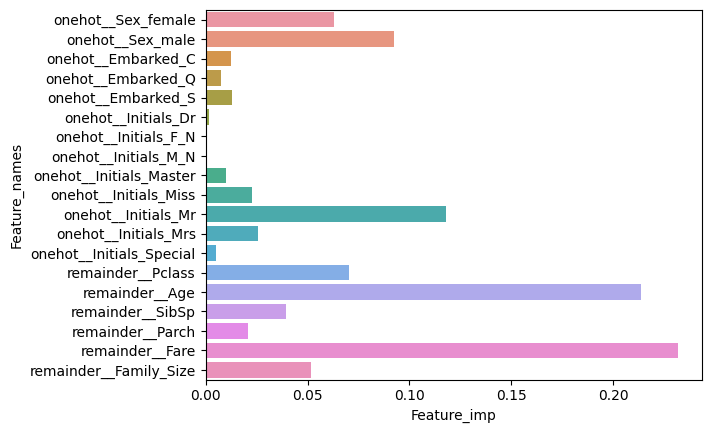

In [46]:
feature_imp_df = pd.DataFrame({"Feature_names": ct_o.get_feature_names_out(), "Feature_imp": forest_imp})
display(feature_imp_df.head())
sns.barplot(data=feature_imp_df, y="Feature_names", x="Feature_imp")

<AxesSubplot: xlabel='Feature_imp', ylabel='Feature_names'>

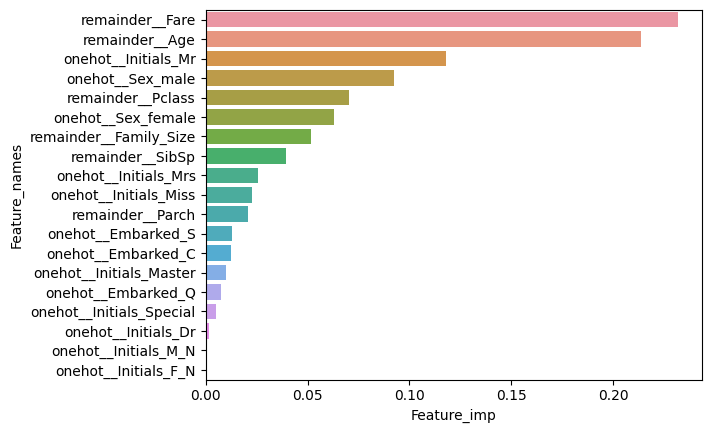

In [49]:
feature_imp_df.sort_values(by=["Feature_imp"], ascending=False, inplace=True)
sns.barplot(data=feature_imp_df, y="Feature_names", x="Feature_imp")